## Ejemplo 1: Pruebas A/B

### 1. Objetivos:
    - Aprender a evaluar los resultados de una Prueba A/B
 
---
    
### 2. Desarrollo:

El siguiente es un dataset obtenido con los resultados de una Prueba A/B. Se probaron dos flujos de venta distintos y se registró si cada uno de ellos resultó en una conversión (venta) o no. El test A es la hipótesis alternativa (la aplicada al grupo experimental), mientras que el test B es la hipótesis nula (la aplicada al grupo control).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../Datasets/ab_test-sales_pipeline.csv')

df

,test,conversion,no conversion
0,B,0,1
1,A,0,1
2,A,0,1
3,A,0,1
4,A,0,1
...,...,...,...
46322,B,0,1
46323,B,0,1
46324,B,0,1
46325,A,0,1


Lo primero que podemos hacer es agrupar nuestros resultados por 'test', para realizar un conteo de cuántas conversiones hubo con cada flujo de ventas:

In [3]:
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()

total_count

,conversion,no conversion
test,,
A,198,23541
B,184,22404


Saquemos la proporción de conversiones que hubo comparadas con el total de pruebas que se realizaron:

In [4]:
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])

total_count

,conversion,no conversion,success rate
test,,,
A,198,23541,0.008341
B,184,22404,0.008146


Con estos datos parecería que el flujo A (la hipótesis alternativa) es superior al flujo B. Veamos qué tan superior:

In [5]:
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100

In [6]:
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más efectivo que el test B para generar ventas.')

El test A fue 2.34% más efectivo que el test B para generar ventas.


¿Ahora, podemos entonces concluir que el flujo de ventas A es mejor que el B? No tan rápido. Vamos a aplicar un test de permutación para saber si nuestro hallazgo es estadísticamente significativo.

Primero tenemos que mezclar las mediciones del test A y el B en el mismo DataFrame. Esto ya está hecho, entonces solamente vamos a eliminar la columna 'test' para que no haya manera de diferenciarlos:

In [7]:
all_measurements = df[['conversion', 'no conversion']]

Ahora necesitamos saber cuántos tests con el flujo A hubieron para poder generar muestras del mismo tamaño exactamente:

In [8]:
value_counts = df['test'].value_counts()

value_counts

A    23739
B    22588
Name: test, dtype: int64

Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.

In [9]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['A'], replace=False)
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    b = df.loc[~df.index.isin(a.index)]
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

In [10]:
perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b
0,170,23569,212,22376
1,210,23529,172,22416
2,192,23547,190,22398
3,196,23543,186,22402
4,199,23540,183,22405
...,...,...,...,...
995,192,23547,190,22398
996,212,23527,170,22418
997,211,23528,171,22417
998,211,23528,171,22417


In [11]:
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [12]:
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,170,23569,212,22376,0.007161,0.009386
1,210,23529,172,22416,0.008846,0.007615
2,192,23547,190,22398,0.008088,0.008412
3,196,23543,186,22402,0.008256,0.008234
4,199,23540,183,22405,0.008383,0.008102
...,...,...,...,...,...,...
995,192,23547,190,22398,0.008088,0.008412
996,212,23527,170,22418,0.008930,0.007526
997,211,23528,171,22417,0.008888,0.007570
998,211,23528,171,22417,0.008888,0.007570


In [13]:
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,170,23569,212,22376,0.007161,0.009386,-0.310604
1,210,23529,172,22416,0.008846,0.007615,0.139217
2,192,23547,190,22398,0.008088,0.008412,-0.040009
3,196,23543,186,22402,0.008256,0.008234,0.002664
4,199,23540,183,22405,0.008383,0.008102,0.033543
...,...,...,...,...,...,...,...
995,192,23547,190,22398,0.008088,0.008412,-0.040009
996,212,23527,170,22418,0.008930,0.007526,0.157252
997,211,23528,171,22417,0.008888,0.007570,0.148277
998,211,23528,171,22417,0.008888,0.007570,0.148277


Ya tenemos nuestros resultados, vamos a ver dónde cae en nuestra distribución el resultado que obtuvimos en nuestro experimento:

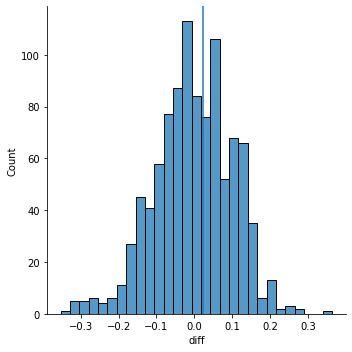

In [14]:
sns.displot(perm_results['diff'], kde=False)

plt.axvline(diferencia_en_proporcion);

Solamente de ver la histograma podemos concluir que nuestro resultado es de hecho bastante típico. Un gran número de modelos realizados totalmente al azar tuvieron valores iguales o más extremos que el que obtuvimos en nuestro experimento.

Vamos ahora a obtener el Valor P para cuantificar numéricamente nuestro resultado:

In [16]:
(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0]

0.43

In [15]:
perm_results.shape[0]

1000

Este valor quiere decir que el 41.6% de los test que hicimos obtuvieron un valor igual o más extremo que el obtenido en el experimento. Esto está extremadamente alejado de un Alfa de 5%, y por lo tanto definitivamente nuestro resultado **no es estadísticamente significativo**.